## Overview

### Purpose
The purpose of this project is to develop a predictive model which will help hospitals
reduce their readmission rates among diabetic patients. <br>

### Introduction
A goal of the Affordable Health Care act is to increase the quality of hospital care in U.S hospitals. One specific issue area in which hospitals can improve quality is by improving hospital readmission rates. Under the Affordable Care Act, CMS created the Hospital Readmission Reduction Program in order to link payment data to the quality of hospital care in order to improve health quality for Americans. Essentially, payments to Inpatient Prospective Payment System (IPPS) hospitals depend on each hospital’s readmission rates. Hospitals with poor readmission performance are financially penalized through reduced payments.

#### Hospital Readmission Definitions according to CMS:
The 30-day risk standardized readmission measures include:
- All-cause unplanned readmissions that happen within 30 days of discharge from the index (i.e., initial) admission.
- Patients who are readmitted to the same hospital, or another applicable acute care hospital for any reason.

### Challenge
Develop a model which predicts whether a patient will be readmitted in under 30 days. A diabetic readmission reduction program intervention will use this model in order to target patients at high risk for readmission. Models will be evaluated on __AUC__ and __FPR__.

### Deliverables
Model which predicts <30 readmission

### Data
See data_prep.ipynb in current directory for data preperation efforts. The data cleaning steps has been organized into preprocess.py. 

### Conclusion
If the focus is prediction accuracy (measured by balance of True Positive Rate and False Positive Rate) then we opt Neural Networks.
If the focus is model interpretability
If the focus in both prediction and interpretability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500


# from preprocess import clean_data 
# df = clean_data()
# we will directly import processed data from csv file to save loading time.
df = pd.read_csv('./data/df_preprocessed.csv')
df.sample(5)

patient_nbr             race  gender      age  admission_type_id  \
60587        87183  AfricanAmerican    Male  [40-50)                  1   
67934     86516685        Caucasian    Male  [70-80)                  1   
69642    102869964        Caucasian    Male  [80-90)                  3   
42409     71726355        Caucasian  Female  [80-90)                  3   
51514     89245638        Caucasian  Female  [70-80)                  3   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
60587                         1                    7                 5   
67934                         1                    7                 2   
69642                         1                    1                 1   
42409                         1                    1                 1   
51514                         3                    1                 3   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
60587                  51               0               22                  0   
67934                  67               0                8                  0   
69642                  33               4                6                  0   
42409                   2               1               10                  0   
51514                  47               3               23                  0   

       number_emergency  number_inpatient           diag_1         diag_2  \
60587                 0                 0      Circulatory       Diabetes   
67934                 0                 0        Neoplasms          Other   
69642                 0                 0      Circulatory  Genitourinary   
42409                 0                 1           Injury    Circulatory   
51514                 0                 0  Musculoskeletal          Other   

            diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
60587  Circulatory                 8          None        >8        Up   
67934  Respiratory                 9          None      None        No   
69642  Circulatory                 6          None      None        No   
42409        Other                 6          None      None        No   
51514  Circulatory                 6          None        >7        No   

      repaglinide nateglinide chlorpropamide glimepiride acetohexamide  \
60587          No          No             No          No            No   
67934          No          No             No          No            No   
69642      Steady          No             No          No            No   
42409          No          No             No          No            No   
51514          No          No             No          No            No   

      glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose  \
60587      Down        No          No           No            No       No   
67934    Steady        No          No       Steady            No       No   
69642        No        No          No           No            No       No   
42409        No        No          No           No        Steady       No   
51514        No        No          No           No            No       No   

      miglitol troglitazone tolazamide examide citoglipton insulin  \
60587       No           No         No      No          No      No   
67934       No           No         No      No          No      No   
69642       No           No         No      No          No      No   
42409       No           No         No      No          No      No   
51514       No           No         No      No          No    Down   

      glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
60587                  No                  No                       No   
67934                  No                  No                       No   
69642                  No                  No                       No   
42409                  No                  No                       No   
51514            

Our clean data has a mix of categorical and numeric features. patient number is not a useful feature, remove.

In [2]:
df = df.drop(columns=['patient_nbr'])

We have 4 features with missing values

In [3]:
df.isnull().sum()[df.isnull().sum()>0]

race      1909
diag_1      13
diag_2     294
diag_3    1198
dtype: int64

Target variable - imbalance

In [4]:
df['readmitted'].value_counts()

0    61609
1     8834
Name: readmitted, dtype: int64

- this could be delt with by various methods including up/down sampling and class weights in the model itself.

### Missing Value Imputation

In [5]:
df.race = df.race.fillna('Other')
df.diag_1 = df.diag_1.fillna('Other')
df.diag_2 = df.diag_2.fillna('Other')
df.diag_3 = df.diag_3.fillna('Other')

### age

age  readmitted
0    [0-10)    0.000043
1   [10-20)    0.000440
2   [20-30)    0.001718
3   [30-40)    0.004046
4   [40-50)    0.010022
5   [50-60)    0.017816
6   [60-70)    0.028037
7   [70-80)    0.035362
8   [80-90)    0.024303
9  [90-100)    0.003620

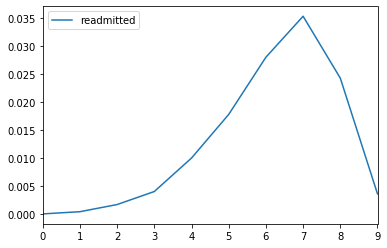

In [6]:
(df.groupby('age').sum()['readmitted']/df.shape[0]).reset_index().plot()
(df.groupby('age').sum()['readmitted']/df.shape[0]).reset_index()

we will explore the effect of treating age as ordinal/numeric features. As shown below, we generalize age into 4 groups. There are different way to create ordinal values, but we will approach with a simple method first and see how our model performs.

In [7]:
(df.age.apply(lambda x: 1 if x == '[0-10}' or x == '[10-20)' else 2 if x == '[20-30)' or x == '[30-40)' 
                        else 4 if x == '[40-50)' or x == '[50-60)' else 6)).value_counts()

6    46950
4    19159
2     3801
1      533
Name: age, dtype: int64

### id columns

__*discharge disposition ids, admission type ids. admission source ids*__

In [8]:
ddi = pd.read_csv('./data/IDs_mapping.csv')

In [9]:
admis_type_id = ddi.iloc[:8,:]
dischar_disp_id = ddi.iloc[10:40,:].rename(columns={'admission_type_id':'discharge_disposition_id'})
admin_source_id = ddi.iloc[42:,:].rename(columns={'admission_type_id':'admission_source_id'})
pd.set_option('display.max_colwidth', -1)
dischar_disp_id

discharge_disposition_id  \
10  1                         
11  2                         
12  3                         
13  4                         
14  5                         
15  6                         
16  7                         
17  8                         
18  9                         
19  10                        
20  11                        
21  12                        
22  13                        
23  14                        
24  15                        
25  16                        
26  17                        
27  18                        
28  19                        
29  20                        
30  21                        
31  22                        
32  23                        
33  24                        
34  25                        
35  26                        
36  30                        
37  27                        
38  28                        
39  29                        

                                                                                                  description  
10  Discharged to home                                                                                         
11  Discharged/transferred to another short term hospital                                                      
12  Discharged/transferred to SNF                                                                              
13  Discharged/transferred to ICF                                                                              
14  Discharged/transferred to another type of inpatient care institution                                       
15  Discharged/transferred to home with home health service                                                    
16  Left AMA                                                                                                   
17  Discharged/transferred to home under care of Home IV provider                                              
18  Admitted as an inpatient to this hospital                                                                  
19  Neonate discharged to another hospital for neonatal aftercare                                              
20  Expired                                                                                                    
21  Still patient or expected to return for outpatient services                                                
22  Hospice / home                                                                                             
23  Hospice / medical facility                                                                                 
24  Discharged/transferred within this institution to Medicare approved swing bed                              
25  Discharged/transferred/referred another institution for outpatient services                                
26  Discharged/transferred/referred to this institution for outpatient services                                
27  NaN                                                                                                        
28  Expired at home. Medicaid only, hospice.                                                                   
29  Expired in a medical facility. Medicaid only, hospice.                                                     
30  Expired, place unknown. Medicaid only, hospice.                                                            
31  Discharged/transferred to another rehab fac including rehab units of a hospital .                          
32  Discharged/transferred to a long term care hospital.                                                       
33  Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.    
34  Not Mapped                                                                                                 
35  Unknown/Invalid                                                                                            
36  Discharged/tr

#### Observation: we can group the descriptions to 5 categories: discharged to home, discharged/transferred to short term facility,  discharged/transferred to long term facility, discharged/transferred to critical care facility, hospice, unknown. 

- id 7: Left AMA: When a patient leaves AMA, the patient is leaving before their treating physician recommends discharge or despite medical advice to the contrary. 
- hospice: a home providing care for the sick or terminally ill.
- id 3 SNF: Skilled nursing facility (SNF) care is post-hospital care provided at a SNF. 

- id 4 ICF: [What is the difference between skilled nursing (SNF) and intermediate care facility (ICF) care?](https://leahi.hhsc.org/patients-and-visitors/faq/#:~:text=What%20is%20the%20difference%20between%20skilled%20nursing%20(SNF)%20and%20intermediate,provide%2024%2Dhour%20skilled%20care.&text=Residents%20of%20an%20intermediate%20care,day%2Dto%2Dday%20living)
A skilled nursing facility is required to provide 24-hour skilled care. Residents of skilled nursing facilities need assistance with many aspects of day-to-day living and daily care. Skilled nursing facilities provide medical, nursing, dietary, pharmacy and activity services.
- id 10 neonatal: new born child care

An intermediate care facility is required to provide custodial daily care. Residents of an intermediate care facility require less assistance with day-to-day living.

In [10]:
disch_disp_dict = {}
disch_disp_dict['discharged to home'] = [1,6,8]
disch_disp_dict['to another facility (incl. ST or LT)'] = [2, 3, 4, 5, 10, 16, 22, 23, 24,30, 27,28]
disch_disp_dict['to the same facility'] = [12, 15, 17]
# disch_disp_dict['to critical care'] = [29, ] # no observation of this type in our data so far.
disch_disp_dict['hospice'] = [13, 14,  10, 19, 20, 21]
disch_disp_dict['Unknown'] = [7, 9, 11, 18, 25, 26, ]
print(disch_disp_dict)

DISCHARGE_DISPO = df.discharge_disposition_id.apply(lambda x: [k  for (k, v) in disch_disp_dict.items() if x in v][0])

{'discharged to home': [1, 6, 8], 'to another facility (incl. ST or LT)': [2, 3, 4, 5, 10, 16, 22, 23, 24, 30, 27, 28], 'to the same facility': [12, 15, 17], 'hospice': [13, 14, 10, 19, 20, 21], 'Unknown': [7, 9, 11, 18, 25, 26]}


We can group NaN, Not Mapped, and Not Available as Unknown

In [11]:
display(admis_type_id)

admis_type_dict = {}
admis_type_dict['Emergency'] = [1]
admis_type_dict['Urgent'] = [2]
admis_type_dict['Elective'] = [3]
admis_type_dict['Newborn'] = [4]
admis_type_dict['Unknown'] = [5,6,8]
admis_type_dict['Trauma Center'] = [7]
print(admis_type_dict)

ADMIN_TYPE = df.admission_type_id.apply(lambda x: [k  for (k, v) in admis_type_dict.items() if x in v][0])


admission_type_id    description
0  1                 Emergency    
1  2                 Urgent       
2  3                 Elective     
3  4                 Newborn      
4  5                 Not Available
5  6                 NaN          
6  7                 Trauma Center
7  8                 Not Mapped

{'Emergency': [1], 'Urgent': [2], 'Elective': [3], 'Newborn': [4], 'Unknown': [5, 6, 8], 'Trauma Center': [7]}


Grouping: Referral, Transfer from facility, Emergency Rm, Law Enforcement, Unknown, Birth, readmission,

In [12]:
display(admin_source_id)

admis_src_dict = {}
admis_src_dict['Referral'] = [1,2,3,11, 12, 14, 23, 24]
admis_src_dict['Transfer'] = [4, 5, 6,10, 18, 22, 25, 26 ]
admis_src_dict['Emergency Rm'] = [7, 13, ]
admis_src_dict['Law Enforc'] = [8]
admis_src_dict['Unknown'] = [9,15, 17, 20, 21]
#admis_src_dict['Birth'] = [11, 12, 14, 23, 24,  ]
#admis_src_dict['Readmission'] = [19 ] # no observation in our dataset.
print(admis_type_dict)

ADMIN_SOURCE = df.admission_source_id.apply(lambda x: [k  for (k, v) in admis_src_dict.items() if x in v][0])

admission_source_id  \
42  1                    
43  2                    
44  3                    
45  4                    
46  5                    
47  6                    
48  7                    
49  8                    
50  9                    
51  10                   
52  11                   
53  12                   
54  13                   
55  14                   
56  15                   
57  17                   
58  18                   
59  19                   
60  20                   
61  21                   
62  22                   
63  23                   
64  24                   
65  25                   
66  26                   

                                                   description  
42   Physician Referral                                         
43  Clinic Referral                                             
44  HMO Referral                                                
45  Transfer from a hospital                                    
46   Transfer from a Skilled Nursing Facility (SNF)             
47   Transfer from another health care facility                 
48   Emergency Room                                             
49   Court/Law Enforcement                                      
50   Not Available                                              
51   Transfer from critial access hospital                      
52  Normal Delivery                                             
53   Premature Delivery                                         
54   Sick Baby                                                  
55   Extramural Birth                                           
56  Not Available                                               
57  NaN                                                         
58   Transfer From Another Home Health Agency                   
59  Readmission to Same Home Health Agency                      
60   Not Mapped                                                 
61  Unknown/Invalid                                             
62   Transfer from hospital inpt/same fac reslt in a sep claim  
63   Born inside this hospital                                  
64   Born outside this hospital                                 
65   Transfer from Ambulatory Surgery Center                    
66  Transfer from Hospice

{'Emergency': [1], 'Urgent': [2], 'Elective': [3], 'Newborn': [4], 'Unknown': [5, 6, 8], 'Trauma Center': [7]}


Birth has only 3 observations. Grouping this into Referral as often it is referred to the hospital by obgyn.

### Numeric Features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff80eea2590>,
      dtype=object)

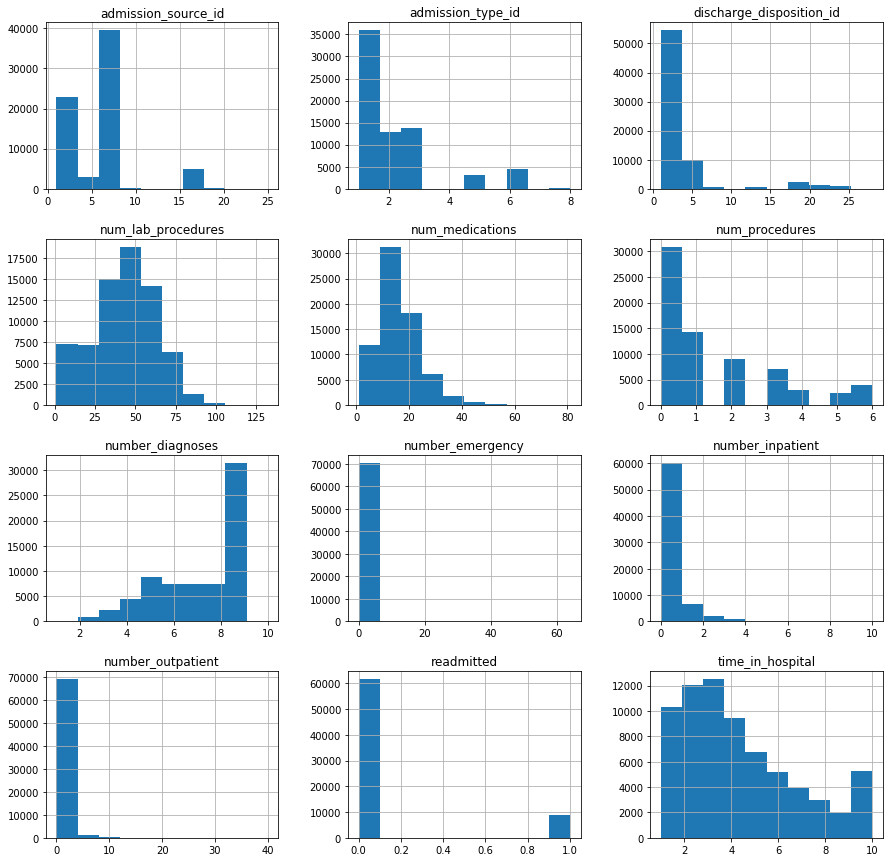

In [13]:
df.hist(figsize = (15, 15))

- We will perform logarithmic transformation to the following features as they are skewed:
    - num_medications, num_procedures, number_diagnoses, number_emergency, number_inpatient, number_outpatient, time_in_hospital
- Additionally, we will scale the post log transformed values so they are on the same scale.

### Train Test Split and Preprocess

In [14]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

def split_train_test(df, age_as_numeric = False, reengin_ids = False, create_diabetes_feat = False):
    
    copy = df.copy()
    if create_diabetes_feat:
        copy['is_diag1_diabetes'] = copy.diag_1.apply(lambda x: 1 if x == 'Diabetes' else 0)
        copy['is_diag2_diabetes'] = copy.diag_2.apply(lambda x: 1 if x == 'Diabetes' else 0)
        copy['is_diag3_diabetes'] = copy.diag_3.apply(lambda x: 1 if x == 'Diabetes' else 0)
    
    seedn = 1234
    y = copy.pop('readmitted')
    X = copy
    
    numeric = X.select_dtypes('int64').columns.tolist()
    categorical = X.select_dtypes('object').columns.tolist()
    ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
    log_transform = ['num_medications', 'num_procedures', 'number_diagnoses', 'number_emergency', 'number_inpatient', 'number_outpatient', 'time_in_hospital']

    for col in ids: # numercally encoded but represent categorical information
        numeric.remove(col)
        categorical.append(col)
        
    if create_diabetes_feat:
        for col in ['is_diag1_diabetes','is_diag2_diabetes','is_diag3_diabetes']:
            numeric.remove(col) # we don't want to scale them later

    if age_as_numeric:
        numeric.append('age')
        categorical.remove('age')
        X['age'] = X.age.apply(lambda x: 1 if x == '[0-10}' or x == '[10-20)' else 2 if x == '[20-30)' or x == '[30-40)' 
                        else 4 if x == '[40-50)' or x == '[50-60)' else 6 if x == '[60-70)' else 8 if x == '[70-80)' else 10)
    if reengin_ids:
        tmp = X.drop(columns= ids).reset_index(drop=True)
        X = pd.concat([tmp, pd.DataFrame(zip(ADMIN_TYPE, DISCHARGE_DISPO, ADMIN_SOURCE), columns=ids)], axis = 1)
    
    for col in log_transform:
        X[col] = np.log1p(X[col]) # log(x+1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seedn)
    
    # dummify
    ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
    ohe.fit(X_train[categorical])
    colname = [str(categorical[int(x.split('_')[0][1:])]) + '_' + x.split('_')[1] for x in ohe.get_feature_names()]
    X_train_cat = pd.DataFrame(ohe.transform(X_train[categorical]), columns=colname)
    X_test_cat = pd.DataFrame(ohe.transform(X_test[categorical]), columns=colname)

    X_train = pd.concat([X_train.drop(columns=categorical).reset_index(drop=True), X_train_cat], axis=1)
    X_test = pd.concat([X_test.drop(columns=categorical).reset_index(drop=True), X_test_cat], axis=1)


    sc = StandardScaler() # scale
    sc.fit(X_train[numeric])
    X_train_num = pd.DataFrame(sc.transform(X_train[numeric]), columns=numeric)
    X_test_num = pd.DataFrame(sc.transform(X_test[numeric]), columns=numeric)

    X_train = pd.concat([X_train.drop(columns=numeric).reset_index(drop=True), X_train_num], axis=1)
    X_test = pd.concat([X_test.drop(columns=numeric).reset_index(drop=True), X_test_num], axis=1)
    
    return (X_train, X_test, y_train, y_test)

#### inspect the trainng data before feeding into the models

In [15]:
X_train, X_test, y_train, y_test = split_train_test(df)

display(X_train.sample(5))

race_AfricanAmerican  race_Asian  race_Caucasian  race_Hispanic  \
32264  0.0                   0.0         1.0             0.0             
10486  1.0                   0.0         0.0             0.0             
16369  1.0                   0.0         0.0             0.0             
19109  0.0                   0.0         0.0             0.0             
34906  0.0                   0.0         1.0             0.0             

       race_Other  gender_Female  gender_Male  age_[0-10)  age_[10-20)  \
32264  0.0         1.0            0.0          0.0         0.0           
10486  0.0         0.0            1.0          0.0         0.0           
16369  0.0         1.0            0.0          0.0         0.0           
19109  1.0         1.0            0.0          0.0         0.0           
34906  0.0         1.0            0.0          0.0         0.0           

       age_[20-30)  age_[30-40)  age_[40-50)  age_[50-60)  age_[60-70)  \
32264  0.0          0.0          0.0          0.0          1.0           
10486  0.0          0.0          0.0          0.0          1.0           
16369  0.0          0.0          0.0          0.0          1.0           
19109  0.0          0.0          0.0          1.0          0.0           
34906  0.0          0.0          0.0          0.0          0.0           

       age_[70-80)  age_[80-90)  age_[90-100)  diag_1_Circulatory  \
32264  0.0          0.0          0.0           1.0                  
10486  0.0          0.0          0.0           0.0                  
16369  0.0          0.0          0.0           0.0                  
19109  0.0          0.0          0.0           1.0                  
34906  0.0          1.0          0.0           1.0                  

       diag_1_Diabetes  diag_1_Digestive  diag_1_Genitourinary  diag_1_Injury  \
32264  0.0              0.0               0.0                   0.0             
10486  1.0              0.0               0.0                   0.0             
16369  1.0              0.0               0.0                   0.0             
19109  0.0              0.0               0.0                   0.0             
34906  0.0              0.0               0.0                   0.0             

       diag_1_Musculoskeletal  diag_1_Neoplasms  diag_1_Other  \
32264  0.0                     0.0               0.0            
10486  0.0                     0.0               0.0            
16369  0.0                     0.0               0.0            
19109  0.0                     0.0               0.0            
34906  0.0                     0.0               0.0            

       diag_1_Respiratory  diag_2_Circulatory  diag_2_Diabetes  \
32264  0.0                 1.0                 0.0               
10486  0.0                 0.0                 0.0               
16369  0.0                 0.0                 0.0               
19109  0.0                 1.0                 0.0               
34906  0.0                 0.0                 0.0               

       diag_2_Digestive  diag_2_Genitourinary  diag_2_Injury  \
32264  0.0               0.0                   0.0             
10486  0.0               0.0                   0.0             
16369  0.0               0.0                   0.0             
19109  0.0               0.0                   0.0             
34906  0.0               0.0                   0.0             

       diag_2_Musculoskeletal  diag_2_Neoplasms  diag_2_Other  \
32264  0.0                     0.0               0.0            
10486  0.0                     0.0               1.0            
16369  0.0                     0.0               1.0            
19109  0.0                     0.0               0.0            
34906  0.0                     0.0               0.0            

       diag_2_Respiratory  diag_3_Circulatory  diag_3_Diabetes  \
32264  0.0                 1.0                 0.0               
10486  0.0                 0.0                 0.0               
16369  0

### Models

#### Define evaluation strategy

In [16]:
def TPR_FPR(mat):
    # TPR = TP/P = TP/(TP + FN)
    # FPR = FP/N = FP/(FP + TN)
    TP = mat[0,0]
    TN = mat[1,1]
    FP = mat[1,0] 
    FN = mat[0,1]
    return (round(TP/(TP+FN),4), round(FP/(FP + TN),4)) # Return tuple of (TPR, FPR)

#### Cross Validation

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
def run_model(model, X_train, y_train, X_test, y_test):
    # 3 fold cross validation scores
    accuracy = cross_val_score(model, X_train, y_train, cv=3, scoring = 'balanced_accuracy') 
    aucs = cross_val_score(model, X_train, y_train, cv=3, scoring = 'roc_auc')

    model.fit(X_train, y_train) # fit
    y_pred = model.predict(X_test) # predict
    conf_mat = metrics.confusion_matrix(y_test, y_pred, labels = [1,0])
    tpr, fpr = TPR_FPR(conf_mat)
    auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    # print roc curve
    disp = metrics.plot_roc_curve(model, X_test, y_test)
    disp.ax_.set_title('ROC curve')
    print(f'Cross validated Balanced Accuracy = {np.round(np.mean(accuracy),4)} (+/- {np.round(np.std(accuracy),4)}) \n' \
          f'Cross validated AUC-ROC = {np.round(np.mean(aucs),4)} (+/- {np.round(np.std(aucs),4)}) \n' \
          f'Test Set Scores: \n True Positive Rate = {tpr}  False Positive Rate = {fpr}  AUC = {np.round(auc,4)}')
    print(f'Confusion Matrix: \n {conf_mat}')

#### 1a. Logistic Regression

Cross validated Balanced Accuracy = 0.5509 (+/- 0.003) 
Cross validated AUC-ROC = 0.7292 (+/- 0.0084) 
Test Set Scores: 
 True Positive Rate = 0.1046  False Positive Rate = 0.0112  AUC = 0.7337
Confusion Matrix: 
 [[  190  1626]
 [  137 12136]]
CPU times: user 2min 14s, sys: 7.1 s, total: 2min 21s
Wall time: 36.1 s


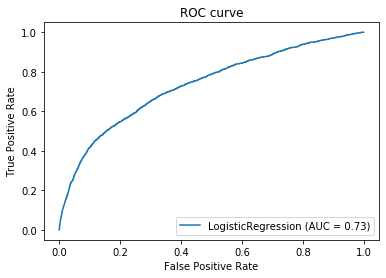

In [18]:
from sklearn.linear_model import LogisticRegression
logit1 = LogisticRegression(max_iter = 1000)
%time run_model(logit1, X_train, y_train, X_test, y_test)

In [19]:
toplot = pd.DataFrame(zip(logit1.coef_.reshape(-1,).tolist(), X_train.columns.tolist()), columns=['coef','feature'])
toplot['importance'] = toplot.coef.apply(lambda x: abs(x))

print('Top 10 features by coeficients \n')
display(toplot.sort_values(by='importance', ascending = False).reset_index()[:10])

Top 10 features by coeficients 



index      coef                      feature  importance
0  154    1.295442  discharge_disposition_id_28  1.295442  
1  141   -1.287756  discharge_disposition_id_13  1.287756  
2  143    1.282885  discharge_disposition_id_15  1.282885  
3  149    1.006400  discharge_disposition_id_22  1.006400  
4  63    -0.881415  nateglinide_Up               0.881415  
5  150   -0.871429  discharge_disposition_id_23  0.871429  
6  142   -0.842875  discharge_disposition_id_14  0.842875  
7  128   -0.832116  admission_type_id_7          0.832116  
8  93     0.783752  acarbose_Up                  0.783752  
9  7     -0.734095  age_[0-10)                   0.734095

#### 1b. Logistic Regression - age as ordinal

In [20]:
X_train2, X_test2, y_train2, y_test2 = split_train_test(df, True)

Cross validated Balanced Accuracy = 0.5512 (+/- 0.0028) 
Cross validated AUC-ROC = 0.7292 (+/- 0.0085) 
Test Set Scores: 
 True Positive Rate = 0.1057  False Positive Rate = 0.0117  AUC = 0.7332
Confusion Matrix: 
 [[  192  1624]
 [  143 12130]]
CPU times: user 1min 46s, sys: 5.45 s, total: 1min 51s
Wall time: 28.6 s


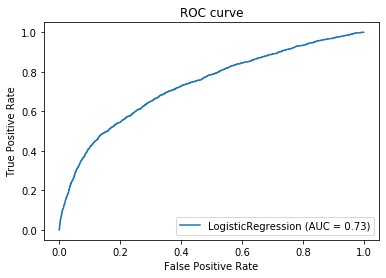

In [21]:
logit2 = LogisticRegression(max_iter = 1000)
%time run_model(logit2, X_train2, y_train2, X_test2, y_test2)

In [22]:
toplot = pd.DataFrame(zip(logit2.coef_.reshape(-1,).tolist(), X_train2.columns.tolist()), columns=['coef','feature'])
toplot['importance'] = toplot.coef.apply(lambda x: abs(x))

print('Top 10 features by coeficients \n')
display(toplot.sort_values(by='importance', ascending = False).reset_index()[:10])

Top 10 features by coeficients 



index      coef                      feature  importance
0  131   -1.295412  discharge_disposition_id_13  1.295412  
1  144    1.283341  discharge_disposition_id_28  1.283341  
2  133    1.281274  discharge_disposition_id_15  1.281274  
3  139    0.999910  discharge_disposition_id_22  0.999910  
4  53    -0.938312  nateglinide_Up               0.938312  
5  140   -0.885998  discharge_disposition_id_23  0.885998  
6  118   -0.879054  admission_type_id_7          0.879054  
7  132   -0.856315  discharge_disposition_id_14  0.856315  
8  83     0.766672  acarbose_Up                  0.766672  
9  128    0.729541  discharge_disposition_id_9   0.729541

### 1c. Logistic Regression  - cleanup id columns

In [23]:
X_train3, X_test3, y_train3, y_test3 = split_train_test(df, False, True)

Cross validated Balanced Accuracy = 0.5482 (+/- 0.003) 
Cross validated AUC-ROC = 0.7263 (+/- 0.0058) 
Test Set Scores: 
 True Positive Rate = 0.0975  False Positive Rate = 0.0112  AUC = 0.7239
Confusion Matrix: 
 [[  177  1639]
 [  138 12135]]
CPU times: user 1min 33s, sys: 5.65 s, total: 1min 39s
Wall time: 25.4 s


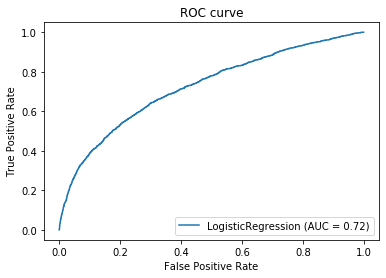

In [24]:
logit3 = LogisticRegression(max_iter = 1000)
%time run_model(logit3, X_train3, y_train3, X_test3, y_test3)

In [25]:
toplot = pd.DataFrame(zip(logit3.coef_.reshape(-1,).tolist(), X_train3.columns.tolist()), columns=['coef','feature'])
toplot['importance'] = toplot.coef.apply(lambda x: abs(x))

print('Top 10 features by coeficients \n')
display(toplot.sort_values(by='importance', ascending = False).reset_index()[:10])

Top 10 features by coeficients 



index      coef                                        feature  importance
0  132    1.132742  discharge_disposition_id_to the same facility  1.132742  
1  130   -1.109067  discharge_disposition_id_hospice               1.109067  
2  63    -0.881320  nateglinide_Up                                 0.881320  
3  7     -0.762557  age_[0-10)                                     0.762557  
4  93     0.756616  acarbose_Up                                    0.756616  
5  125   -0.749032  admission_type_id_Trauma Center                0.749032  
6  144    0.569861  number_inpatient                               0.569861  
7  87    -0.537639  rosiglitazone_Down                             0.537639  
8  59     0.521272  repaglinide_Up                                 0.521272  
9  56    -0.454623  repaglinide_Down                               0.454623

### 1d. Logistic Regression  - create diabetes columns from diagnostic information

Cross validated Balanced Accuracy = 0.5509 (+/- 0.0031) 
Cross validated AUC-ROC = 0.7292 (+/- 0.0084) 
Test Set Scores: 
 True Positive Rate = 0.1046  False Positive Rate = 0.0112  AUC = 0.7336
Confusion Matrix: 
 [[  190  1626]
 [  137 12136]]
CPU times: user 2min 7s, sys: 7.44 s, total: 2min 15s
Wall time: 34.5 s


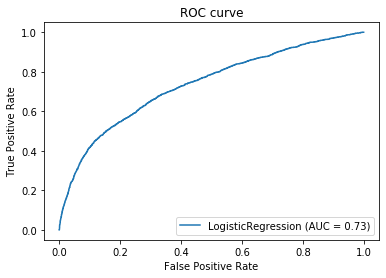

In [26]:
X_train4, X_test4, y_train4, y_test4 = split_train_test(df, False, False, True)
logit4 = LogisticRegression(max_iter = 1000)
%time run_model(logit4, X_train4, y_train4, X_test4, y_test4)

In [27]:
toplot = pd.DataFrame(zip(logit4.coef_.reshape(-1,).tolist(), X_train4.columns.tolist()), columns=['coef','feature'])
toplot['importance'] = toplot.coef.apply(lambda x: abs(x))

print('Top 10 features by coeficients \n')
display(toplot.sort_values(by='importance', ascending = False).reset_index()[:10])

Top 10 features by coeficients 



index      coef                      feature  importance
0  144   -1.294845  discharge_disposition_id_13  1.294845  
1  157    1.277465  discharge_disposition_id_28  1.277465  
2  146    1.271709  discharge_disposition_id_15  1.271709  
3  152    0.999321  discharge_disposition_id_22  0.999321  
4  66    -0.902481  nateglinide_Up               0.902481  
5  153   -0.881533  discharge_disposition_id_23  0.881533  
6  145   -0.852385  discharge_disposition_id_14  0.852385  
7  131   -0.834573  admission_type_id_7          0.834573  
8  10    -0.757928  age_[0-10)                   0.757928  
9  96     0.719235  acarbose_Up                  0.719235

- age as categorical performs slightly better though it seems to be no big different how we treat our age.
- for the rest of the models, we will treat age as the categorical
- from the top 10 features, we see that a lot of importantance is on various discharge_disposition_id. Let's see if we can better engineer the 3 id features: discharge disposition ids, admission type ids. admission source ids to better generalize from data and enhance model performance.
- finally, our model has low false positive rate which is great, but also a very low true positive rate. This is due to the imbalanced dataset. Let's __upsample__ our datasets to ensure our training data sees the same class weights.

### Upsampling

In [29]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

seedn=1234
def upsample(df):
    np.random.seed(seedn) 
    msk = np.random.rand(df.shape[0]) < 0.8
    train = df[msk]
    test = df[~msk]
    print(f'Train:\n{train.readmitted.value_counts()}\nTest:\n{test.readmitted.value_counts()}')

    yes = train[train['readmitted']==1]
    no = train[train['readmitted']==0]
    n = no.shape[0]
    no = no.sample(n=n, replace = True, random_state = seedn)
    yes = yes.sample(n=n, replace = True, random_state = seedn)
    train_up = pd.concat([yes,no], axis = 0)
    print(f'Train upsampled: \n{train_up.readmitted.value_counts()}')
    print(f'Test: \n{test.readmitted.value_counts()}')
    return train_up, test

def upsampled_train_test_split(df, age_as_numeric = False, reengin_ids = False, create_diabetes_feat = False):
    
    copy = df.copy()
    if create_diabetes_feat:
        copy['is_diag1_diabetes'] = copy.diag_1.apply(lambda x: 1 if x == 'Diabetes' else 0)
        copy['is_diag2_diabetes'] = copy.diag_2.apply(lambda x: 1 if x == 'Diabetes' else 0)
        copy['is_diag3_diabetes'] = copy.diag_3.apply(lambda x: 1 if x == 'Diabetes' else 0)
    numeric = copy.select_dtypes('int64').columns.tolist()
    numeric.remove('readmitted')
    categorical = copy.select_dtypes('object').columns.tolist()
    
    ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
    log_transform = ['num_medications', 'num_procedures', 'number_diagnoses', 'number_emergency', 'number_inpatient', 'number_outpatient', 'time_in_hospital']
    
    for col in ids:
        numeric.remove(col)
        categorical.append(col)
        
    if age_as_numeric:
        numeric.append('age')
        categorical.remove('age')
        copy['age'] = copy.age.apply(lambda x: 1 if x == '[0-10}' or x == '[10-20)' else 2 if x == '[20-30)' or x == '[30-40)' 
                        else 4 if x == '[40-50)' or x == '[50-60)' else 6 if x == '[60-70)' else 8 if x == '[70-80)' else 10)
        
    if reengin_ids:
        tmp = copy.drop(columns= ids).reset_index(drop=True)
        copy = pd.concat([tmp, pd.DataFrame(zip(ADMIN_TYPE, DISCHARGE_DISPO, ADMIN_SOURCE), columns=ids)], axis = 1)
    
    for col in log_transform:
        copy[col] = np.log1p(copy[col]) # log(x+1)
    
    train_df, test_df = upsample(copy)
    
    y_train = train_df.pop('readmitted')
    X_train = train_df
    y_test = test_df.pop('readmitted')
    X_test = test_df
    
    ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
    ohe.fit(X_train[categorical])
    colname = [str(categorical[int(x.split('_')[0][1:])]) + '_' + x.split('_')[1] for x in ohe.get_feature_names()]
    X_train_cat = pd.DataFrame(ohe.transform(X_train[categorical]), columns=colname)
    X_test_cat = pd.DataFrame(ohe.transform(X_test[categorical]), columns=colname)

    X_train = pd.concat([X_train.drop(columns=categorical).reset_index(drop=True), X_train_cat], axis=1)
    X_test = pd.concat([X_test.drop(columns=categorical).reset_index(drop=True), X_test_cat], axis=1)


    sc = StandardScaler()
    sc.fit(X_train[numeric])
    X_train_num = pd.DataFrame(sc.transform(X_train[numeric]), columns=numeric)
    X_test_num = pd.DataFrame(sc.transform(X_test[numeric]), columns=numeric)

    X_train = pd.concat([X_train.drop(columns=numeric).reset_index(drop=True), X_train_num], axis=1)
    X_test = pd.concat([X_test.drop(columns=numeric).reset_index(drop=True), X_test_num], axis=1)
    
    return (X_train, X_test, y_train, y_test)

In [30]:
X_train_up, X_test_up, y_train_up, y_test_up = upsampled_train_test_split(df)

Train:
0    49290
1    6998 
Name: readmitted, dtype: int64
Test:
0    12319
1    1836 
Name: readmitted, dtype: int64
Train upsampled: 
1    49290
0    49290
Name: readmitted, dtype: int64
Test: 
0    12319
1    1836 
Name: readmitted, dtype: int64


#### 1d. Logistic Regression - Upsampled

Cross validated Balanced Accuracy = 0.6772 (+/- 0.0012) 
Cross validated AUC-ROC = 0.7411 (+/- 0.0018) 
Test Set Scores: 
 True Positive Rate = 0.5648  False Positive Rate = 0.2308  AUC = 0.7267
Confusion Matrix: 
 [[1037  799]
 [2843 9476]]
CPU times: user 4min 37s, sys: 14.3 s, total: 4min 51s
Wall time: 1min 14s


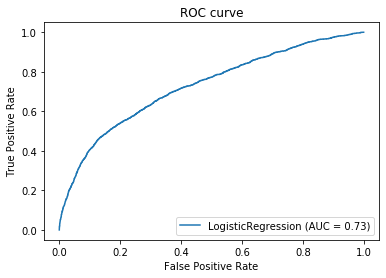

In [45]:
from sklearn.linear_model import LogisticRegression
logit_up = LogisticRegression(max_iter = 2000)
%time run_model(logit_up, X_train_up, y_train_up, X_test_up, y_test_up)

In [46]:
toplot = pd.DataFrame(zip(logit_up.coef_.reshape(-1,).tolist(), X_train_up.columns.tolist()), columns=['coef','feature'])
toplot['importance'] = toplot.coef.apply(lambda x: abs(x))

print('Top 10 features by coeficients \n')
display(toplot.sort_values(by='importance', ascending = False).reset_index()[:10])

Top 10 features by coeficients 



index      coef                      feature  importance
0  139   -1.861612  discharge_disposition_id_10  1.861612  
1  128   -1.802029  admission_type_id_7          1.802029  
2  154    1.632507  discharge_disposition_id_28  1.632507  
3  143    1.526950  discharge_disposition_id_15  1.526950  
4  138    1.476168  discharge_disposition_id_9   1.476168  
5  140    1.346246  discharge_disposition_id_12  1.346246  
6  141   -1.324802  discharge_disposition_id_13  1.324802  
7  164   -1.278716  admission_source_id_10       1.278716  
8  63    -1.254133  nateglinide_Up               1.254133  
9  82    -1.237522  tolbutamide_Steady           1.237522

Our importance features changed quite a lot after we upsampled

We could do more here, but let's move onto the decision trees.

#### 2a. Decision Tree

Cross validated Balanced Accuracy = 0.5662 (+/- 0.006) 
Cross validated AUC-ROC = 0.5661 (+/- 0.006) 
Test Set Scores: 
 True Positive Rate = 0.2467  False Positive Rate = 0.1264  AUC = 0.5601
Confusion Matrix: 
 [[  448  1368]
 [ 1551 10722]]
CPU times: user 6.76 s, sys: 167 ms, total: 6.93 s
Wall time: 6.94 s


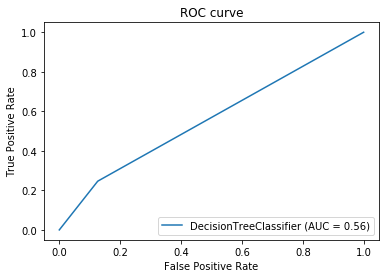

In [33]:
from sklearn.tree import DecisionTreeClassifier

tree1 = DecisionTreeClassifier(random_state=seedn)
%time run_model(tree1, X_train, y_train, X_test, y_test) # not upsampled

Take a look at Sklearn's default params

In [34]:
tree1.get_params 

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')>

- class weight adjusts for class imbalance.

Cross validated Balanced Accuracy = 0.5601 (+/- 0.0013) 
Cross validated AUC-ROC = 0.5601 (+/- 0.0013) 
Test Set Scores: 
 True Positive Rate = 0.2483  False Positive Rate = 0.1195  AUC = 0.5644
Confusion Matrix: 
 [[  451  1365]
 [ 1467 10806]]
CPU times: user 6.05 s, sys: 152 ms, total: 6.2 s
Wall time: 6.22 s


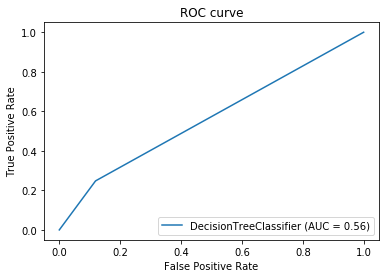

In [35]:
tree1 = DecisionTreeClassifier(class_weight='balanced', random_state=seedn)
%time run_model(tree1, X_train, y_train, X_test, y_test) # not upsampled

- max_depth to tune for overfitting

Cross validated Balanced Accuracy = 0.6682 (+/- 0.0066) 
Cross validated AUC-ROC = 0.7149 (+/- 0.0052) 
Test Set Scores: 
 True Positive Rate = 0.5551  False Positive Rate = 0.225  AUC = 0.7153
Confusion Matrix: 
 [[1008  808]
 [2762 9511]]
CPU times: user 1.77 s, sys: 139 ms, total: 1.91 s
Wall time: 1.91 s


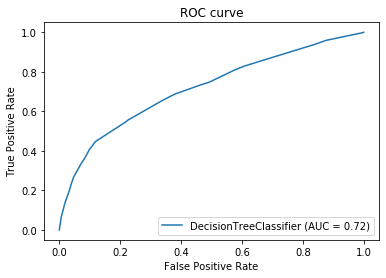

In [36]:
tree1 = DecisionTreeClassifier(class_weight='balanced', random_state=seedn, max_depth = 5)
%time run_model(tree1, X_train, y_train, X_test, y_test) # not upsampled

In [37]:
from sklearn import tree
import graphviz

import matplotlib.pyplot as plt
tree1.fit(X_train, y_train)

dot_data = tree.export_graphviz(tree1, out_file='tree1.dot', 
                feature_names = X_train.columns,
                class_names = 'readmitted',
                rounded = True, proportion = False, 
                precision = 3, filled = True)

# # Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree1.png',width = 900, height = 500) # inspect how it's split, 
# picture doesn't display well on notebook even with width and height adjustment. Open the .png file for clearer visualization.

In [38]:
pd.DataFrame(zip(tree1.feature_importances_.tolist(),X_train.columns.tolist()), columns=['importance','feature']).sort_values(by='importance', ascending = False)

importance                         feature
177  0.735222    number_inpatient              
130  0.120674    discharge_disposition_id_1    
149  0.034958    discharge_disposition_id_22   
178  0.030987    number_diagnoses              
171  0.021208    time_in_hospital              
127  0.015564    admission_type_id_6           
132  0.014090    discharge_disposition_id_3    
17   0.010250    diag_1_Circulatory            
172  0.007250    num_lab_procedures            
135  0.002872    discharge_disposition_id_6    
104  0.002175    insulin_No                    
46   0.002004    max_glu_serum_None            
19   0.001438    diag_1_Digestive              
27   0.001307    diag_2_Diabetes               
124  0.000000    admission_type_id_3           
96   0.000000    miglitol_Steady               
119  0.000000    change_No                     
120  0.000000    diabetesMed_No                
121  0.000000    diabetesMed_Yes               
122  0.000000    admission_type_id_1           
123  0.000000    admission_type_id_2           
126  0.000000    admission_type_id_5           
125  0.000000    admission_type_id_4           
117  0.000000    metformin-pioglitazone_Steady 
95   0.000000    miglitol_No                   
128  0.000000    admission_type_id_7           
129  0.000000    admission_type_id_8           
94   0.000000    miglitol_Down                 
131  0.000000    discharge_disposition_id_2    
118  0.000000    change_Ch                     
114  0.000000    metformin-rosiglitazone_No    
116  0.000000    metformin-pioglitazone_No     
106  0.000000    insulin_Up                    
98   0.000000    troglitazone_Steady           
99   0.000000    tolazamide_No                 
100  0.000000    tolazamide_Steady             
101  0.000000    examide_No                    
102  0.000000    citoglipton_No                
103  0.000000    insulin_Down                  
105  0.000000    insulin_Steady                
107  0.000000    glyburide-metformin_Down      
115  0.000000    metformin-rosiglitazone_Steady
108  0.000000    glyburide-metformin_No        
109  0.000000    glyburide-metformin_Steady    
110  0.000000    glyburide-metformin_Up        
111  0.000000    glipizide-metformin_No        
133  0.000000    discharge_disposition_id_4    
113  0.000000    glimepiride-pioglitazone_No   
97   0.000000    troglitazone_No               
112  0.000000    glipizide-metformin_Steady    
137  0.000000    discharge_disposition_id_8    
134  0.000000    discharge_disposition_id_5    
136  0.000000    discharge_disposition_id_7    
158  0.000000    admission_source_id_4         
159  0.000000    admission_source_id_5         
160  0.000000    admission_source_id_6         
161  0.000000    admission_source_id_7         
162  0.000000    admission_source_id_8         
163  0.000000    admission_source_id_9         
164  0.000000    admission_source_id_10        
165  0.000000    admission_source_id_13        
166  0.000000    admission_source_id_14        
167  0.000000    admission_source_id_17        
168  0.000000    admission_source_id_20        
169  0.000000    admission_source_id_22        
170  0.000000    admission_source_id_25        
173  0.000000    num_procedures                
174  0.000000    num_medications               
175  0.000000    number_outpatient             
176  0.000000    number_emergency              
157  0.000000    admission_source_id_3         
156  0.000000    admission_source_id_2         
155  0.000000    admission_source_id_1         
144  0.000000    discharge_disposition_id_16   
92   0.000000    acarbose_Steady               
138  0.000000    discharge_disposition_id_9    
139  0.000000    discharge_disposition_id_10   
140  0.000000    discharge_disposition_id_12   
141  0.000000    discharge_disposition_id_13   
142  0.000000    discharge_disposition_id_14   
143  0.000000    discharge_disposition_id_15   
145  0.000000    discharge_disposition_id_17   
154  0.000000    disc

#### 2b. Decision Tree - age as ordinal

Cross validated Balanced Accuracy = 0.6662 (+/- 0.0057) 
Cross validated AUC-ROC = 0.7155 (+/- 0.0053) 
Test Set Scores: 
 True Positive Rate = 0.5551  False Positive Rate = 0.225  AUC = 0.7153
Confusion Matrix: 
 [[1008  808]
 [2762 9511]]
CPU times: user 1.79 s, sys: 168 ms, total: 1.96 s
Wall time: 1.97 s


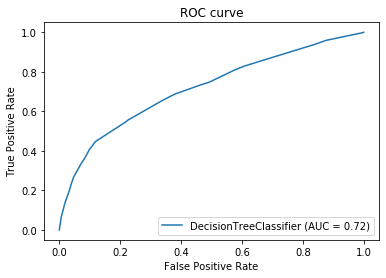

In [39]:
tree2 = DecisionTreeClassifier(class_weight='balanced', random_state=seedn, max_depth = 5)

%time run_model(tree2, X_train2, y_train2, X_test2, y_test2)

- in Decision Trees, the way we treat age doesn't contribute much to the model performance.

#### 2c. Decision Tree - upsampled

Cross validated Balanced Accuracy = 0.6729 (+/- 0.001) 
Cross validated AUC-ROC = 0.7271 (+/- 0.0017) 
Test Set Scores: 
 True Positive Rate = 0.5594  False Positive Rate = 0.2297  AUC = 0.7098
Confusion Matrix: 
 [[1027  809]
 [2830 9489]]
CPU times: user 3.2 s, sys: 275 ms, total: 3.48 s
Wall time: 3.49 s


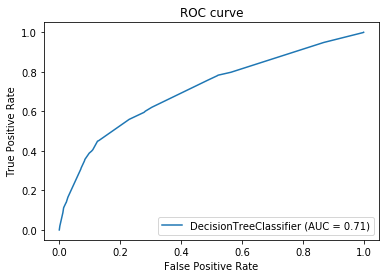

In [40]:
tree3 = DecisionTreeClassifier(random_state=seedn, max_depth = 5)

%time run_model(tree3, X_train_up, y_train_up, X_test_up, y_test_up)

- in decision trees, if we specify class_weight, there is no need to upsample.

#### 2d. Decision Tree - ids re-engineered.

Cross validated Balanced Accuracy = 0.6677 (+/- 0.0071) 
Cross validated AUC-ROC = 0.7148 (+/- 0.0058) 
Test Set Scores: 
 True Positive Rate = 0.6256  False Positive Rate = 0.2831  AUC = 0.7155
Confusion Matrix: 
 [[1136  680]
 [3474 8799]]
CPU times: user 1.53 s, sys: 122 ms, total: 1.66 s
Wall time: 1.66 s


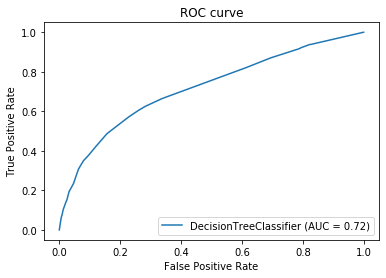

In [41]:
tree4 = DecisionTreeClassifier(random_state=seedn,class_weight='balanced', max_depth = 5)
%time run_model(tree4, X_train3, y_train3, X_test3, y_test3)

#### Feature Importance

In [42]:
pd.DataFrame(zip(tree4.feature_importances_.tolist(),X_train3.columns.tolist()), columns=['importance','feature']).sort_values(by='importance', ascending = False)

importance                                                        feature
144  0.746909    number_inpatient                                             
131  0.127919    discharge_disposition_id_to another facility (incl. ST or LT)
145  0.035001    number_diagnoses                                             
138  0.026331    time_in_hospital                                             
129  0.013320    discharge_disposition_id_discharged to home                  
17   0.010049    diag_1_Circulatory                                           
121  0.008049    diabetesMed_Yes                                              
139  0.006028    num_lab_procedures                                           
133  0.004854    admission_source_id_Emergency Rm                             
143  0.004388    number_emergency                                             
136  0.003266    admission_source_id_Transfer                                 
38   0.002823    diag_3_Genitourinary                                         
130  0.002671    discharge_disposition_id_hospice                             
141  0.002515    num_medications                                              
103  0.002034    insulin_Down                                                 
14   0.001963    age_[70-80)                                                  
26   0.001880    diag_2_Circulatory                                           
99   0.000000    tolazamide_No                                                
91   0.000000    acarbose_No                                                  
100  0.000000    tolazamide_Steady                                            
102  0.000000    citoglipton_No                                               
101  0.000000    examide_No                                                   
98   0.000000    troglitazone_Steady                                          
97   0.000000    troglitazone_No                                              
96   0.000000    miglitol_Steady                                              
95   0.000000    miglitol_No                                                  
94   0.000000    miglitol_Down                                                
93   0.000000    acarbose_Up                                                  
92   0.000000    acarbose_Steady                                              
85   0.000000    pioglitazone_Steady                                          
90   0.000000    rosiglitazone_Up                                             
89   0.000000    rosiglitazone_Steady                                         
88   0.000000    rosiglitazone_No                                             
87   0.000000    rosiglitazone_Down                                           
86   0.000000    pioglitazone_Up                                              
105  0.000000    insulin_Steady                                               
84   0.000000    pioglitazone_No                                              
83   0.000000    pioglitazone_Down                                            
82   0.000000    tolbutamide_Steady                                           
81   0.000000    tolbutamide_No                                               
80   0.000000    glyburide_Up                                                 
79   0.000000    glyburide_Steady                                             
78   0.000000    glyburide_No                                                 
77   0.000000    glyburide_Down                                               
104  0.000000    insulin_No                                                   
112  0.000000    glipizide-metformin_Steady                                   
106  0.000000    insulin_Up                                                   
122  0.000000    admission_type_id_Elective                                   
142  0.000000    number_outpatient                                            
140  0.000000    num_procedures                        

- Re-engineering ids really helps our decision tree perform better.
- So far, decision tree is performing as good as logistic regression with significantly less training time.

#### 2d. Decision Tree - create diabetes columns from diagnostic information

Cross validated Balanced Accuracy = 0.6682 (+/- 0.0066) 
Cross validated AUC-ROC = 0.7149 (+/- 0.0052) 
Test Set Scores: 
 True Positive Rate = 0.5551  False Positive Rate = 0.225  AUC = 0.7153
Confusion Matrix: 
 [[1008  808]
 [2762 9511]]
CPU times: user 2.43 s, sys: 421 ms, total: 2.85 s
Wall time: 2.86 s


importance                                                        feature
144  0.746909    number_inpatient                                             
131  0.127919    discharge_disposition_id_to another facility (incl. ST or LT)
145  0.035001    number_diagnoses                                             
138  0.026331    time_in_hospital                                             
129  0.013320    discharge_disposition_id_discharged to home                  
17   0.010049    diag_1_Circulatory                                           
121  0.008049    diabetesMed_Yes                                              
139  0.006028    num_lab_procedures                                           
133  0.004854    admission_source_id_Emergency Rm                             
143  0.004388    number_emergency                                             
136  0.003266    admission_source_id_Transfer                                 
38   0.002823    diag_3_Genitourinary                                         
130  0.002671    discharge_disposition_id_hospice                             
141  0.002515    num_medications                                              
103  0.002034    insulin_Down                                                 
14   0.001963    age_[70-80)                                                  
26   0.001880    diag_2_Circulatory                                           
99   0.000000    tolazamide_No                                                
91   0.000000    acarbose_No                                                  
100  0.000000    tolazamide_Steady                                            
102  0.000000    citoglipton_No                                               
101  0.000000    examide_No                                                   
98   0.000000    troglitazone_Steady                                          
97   0.000000    troglitazone_No                                              
96   0.000000    miglitol_Steady                                              
95   0.000000    miglitol_No                                                  
94   0.000000    miglitol_Down                                                
93   0.000000    acarbose_Up                                                  
92   0.000000    acarbose_Steady                                              
85   0.000000    pioglitazone_Steady                                          
90   0.000000    rosiglitazone_Up                                             
89   0.000000    rosiglitazone_Steady                                         
88   0.000000    rosiglitazone_No                                             
87   0.000000    rosiglitazone_Down                                           
86   0.000000    pioglitazone_Up                                              
105  0.000000    insulin_Steady                                               
84   0.000000    pioglitazone_No                                              
83   0.000000    pioglitazone_Down                                            
82   0.000000    tolbutamide_Steady                                           
81   0.000000    tolbutamide_No                                               
80   0.000000    glyburide_Up                                                 
79   0.000000    glyburide_Steady                                             
78   0.000000    glyburide_No                                                 
77   0.000000    glyburide_Down                                               
104  0.000000    insulin_No                                                   
112  0.000000    glipizide-metformin_Steady                                   
106  0.000000    insulin_Up                                                   
122  0.000000    admission_type_id_Elective                                   
142  0.000000    number_outpatient                                            
140  0.000000    num_procedures                        

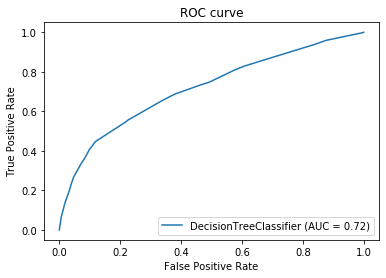

In [44]:
tree5 = DecisionTreeClassifier(random_state=seedn,class_weight='balanced', max_depth = 5)
%time run_model(tree5, X_train4, y_train4, X_test4, y_test4)
display(pd.DataFrame(zip(tree4.feature_importances_.tolist(),X_train3.columns.tolist()), columns=['importance','feature']).sort_values(by='importance', ascending = False))

- we could tune more parameters here, but let's move on to the random forest.

### 3a. Random Forest
